# Transfer Learning in RUL Estimation
## Settings

In [4]:
## Import libraries in python
import argparse
import time
import json
import logging
import sys
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from itertools import repeat
from scipy.stats import randint, expon, uniform

import tensorflow as tf
import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
import cv2
import io
from PIL import Image
from numba import jit, cuda


# Ignore tf err log
pd.options.mode.chained_assignment = None  # default='warn'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

# random seed predictable
seed = 0
random.seed(seed)
np.random.seed(seed)

# Path settings
current_dir = '.'#os.path.dirname(os.path.abspath(__file__))

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path =current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]

## temporary model path for NN
model_path = current_dir +'/temp_net.h5'

# Sensors not to be considered (those that do not disclose any pattern in their ts)
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

#start = time.time()

# Architecture preferences
dp = FD_path[1]
subdataset = dp_str[1]
sequence_length = 32
thres_type = None
thres_value = 50
device = 'cpu'
method = 'rps'
n_hidden1 = 100
n_hidden2 = 10
epochs = 100
batch = 700
verbose = 2
flatten = False
visualize = False



## Recurrent Plot File

In [5]:
'''
Created on April , 2021
@author:
'''
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from pyts.approximation import SymbolicFourierApproximation


def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.

    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]



class input_gen(object):
    '''
    class for data preparation (rps generator)
    '''

    def __init__(self, data_path_list, sequence_length, sensor_drop, piecewise_lin_ref=125, preproc=False, visualize=True):
        '''
        :param data_path_list: python list of four sub-dataset
        :param sequence_length: legnth of sequence (sliced time series)
        :param sensor_drop: sensors not to be considered
        :param piecewise_lin_ref: max rul value (if real rul value is larger than piecewise_lin_ref,
        then the rul value is piecewise_lin_ref)
        :param preproc: preprocessing
        '''
        # self.__logger = logging.getLogger('data preparation for using it as the network input')
        self.data_path_list = data_path_list
        self.sequence_length = sequence_length
        self.sensor_drop = sensor_drop
        self.preproc = preproc
        self.piecewise_lin_ref = piecewise_lin_ref
        self.visualize = visualize


        ## Assign columns name
        cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
        cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
        col_rul = ['RUL_truth']

        train_FD = pd.read_csv(self.data_path_list[0], sep=' ', header=None,
                               names=cols, index_col=False)
        test_FD = pd.read_csv(self.data_path_list[1], sep=' ', header=None,
                              names=cols, index_col=False)
        RUL_FD = pd.read_csv(self.data_path_list[2], sep=' ', header=None,
                             names=col_rul, index_col=False)

        ## Calculate RUL and append to train data
        # get the time of the last available measurement for each unit
        mapper = {}
        for unit_nr in train_FD['unit_nr'].unique():
            mapper[unit_nr] = train_FD['cycles'].loc[train_FD['unit_nr'] == unit_nr].max()

        # calculate RUL = time.max() - time_now for each unit
        train_FD['RUL'] = train_FD['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD['cycles']
        # piecewise linear for RUL labels
        train_FD['RUL'].loc[(train_FD['RUL'] > self.piecewise_lin_ref)] = self.piecewise_lin_ref

        # Cut max RUL ground truth
        RUL_FD['RUL_truth'].loc[(RUL_FD['RUL_truth'] > self.piecewise_lin_ref)] = self.piecewise_lin_ref

        ## Excluse columns which only have NaN as value
        cols_nan = train_FD.columns[train_FD.isna().any()].tolist()
        cols_const = [col for col in train_FD.columns if len(train_FD[col].unique()) <= 2]

        ## Drop exclusive columns
        # train_FD = train_FD.drop(columns=cols_const + cols_nan)
        # test_FD = test_FD.drop(columns=cols_const + cols_nan)

        train_FD = train_FD.drop(columns=cols_const + cols_nan + sensor_drop)

        test_FD = test_FD.drop(columns=cols_const + cols_nan + sensor_drop)


        if self.preproc == True:
            ## preprocessing(normailization for the neural networks)
            min_max_scaler = preprocessing.MinMaxScaler()
            # for the training set
            # train_FD['cycles_norm'] = train_FD['cycles']
            cols_normalize = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])

            norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_FD[cols_normalize]),
                                         columns=cols_normalize,
                                         index=train_FD.index)
            join_df = train_FD[train_FD.columns.difference(cols_normalize)].join(norm_train_df)
            train_FD = join_df.reindex(columns=train_FD.columns)

            # for the test set
            # test_FD['cycles_norm'] = test_FD['cycles']
            cols_normalize_test = test_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2'])
            # print ("cols_normalize_test", cols_normalize_test)
            norm_test_df = pd.DataFrame(min_max_scaler.transform(test_FD[cols_normalize_test]), columns=cols_normalize_test,
                                        index=test_FD.index)
            test_join_df = test_FD[test_FD.columns.difference(cols_normalize_test)].join(norm_test_df)
            test_FD = test_join_df.reindex(columns=test_FD.columns)
            test_FD = test_FD.reset_index(drop=True)
        else:
            # print ("No preprocessing")
            pass

        # Specify the columns to be used
        sequence_cols_train = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])
        sequence_cols_test = test_FD.columns.difference(['unit_nr', 'os_1', 'os_2', 'cycles'])



        ## generator for the sequences
        # transform each id of the train dataset in a sequence
        seq_gen = (list(gen_sequence(train_FD[train_FD['unit_nr'] == id], self.sequence_length, sequence_cols_train))
                   for id in train_FD['unit_nr'].unique())

        # generate sequences and convert to numpy array in training set
        seq_array_train = np.concatenate(list(seq_gen)).astype(np.float32)
        self.seq_array_train = seq_array_train.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        # print("seq_array_train.shape", self.seq_array_train.shape)

        # generate label of training samples
        label_gen = [gen_labels(train_FD[train_FD['unit_nr'] == id], self.sequence_length, ['RUL'])
                     for id in train_FD['unit_nr'].unique()]
        self.label_array_train = np.concatenate(label_gen).astype(np.float32)

        # generate sequences and convert to numpy array in test set (only the last sequence for each engine in test set)
        seq_array_test_last = [test_FD[test_FD['unit_nr'] == id][sequence_cols_test].values[-self.sequence_length:]
                               for id in test_FD['unit_nr'].unique() if
                               len(test_FD[test_FD['unit_nr'] == id]) >= self.sequence_length]

        seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
        self.seq_array_test_last = seq_array_test_last.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        # print("seq_array_test_last.shape", self.seq_array_test_last.shape)

        # generate label of test samples
        y_mask = [len(test_FD[test_FD['unit_nr'] == id]) >= self.sequence_length for id in test_FD['unit_nr'].unique()]
        label_array_test_last = RUL_FD['RUL_truth'][y_mask].values
        self.label_array_test = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)


        ## Visualize Run-2-failure TS of the first engine in the training set.(Please deactivate after understanding)
        if self.visualize == True:
            # R2F TS of the first engine
            pd.DataFrame(train_FD[train_FD['unit_nr'] == 1][sequence_cols_train].values,
                             columns=sequence_cols_train).plot(subplots=True, figsize=(15, 15))

            # The last sequences sliced from each TS (of the first engine)
            prop_cycle = plt.rcParams['axes.prop_cycle']
            colors = prop_cycle.by_key()['color']
            colors = colors + colors + colors

            seq_gen = (
            list(gen_sequence(train_FD[train_FD['unit_nr'] == id], self.sequence_length, sequence_cols_train))
            for id in train_FD['unit_nr'].unique())

            seq_list_engine = list(seq_gen)
            seq_engine_1_array = np.asarray(seq_list_engine[0])

            last_seq_engine_1_array = seq_engine_1_array[-1, :, :]
            fig_ts = plt.figure(figsize=(15, 15))
            for s in range(last_seq_engine_1_array.shape[1]):
                seq_s = last_seq_engine_1_array[:, s]
                # plt.subplot(last_seq_engine_1_array.shape[1],(s//4) + 1, (s%4)+1)
                plt.subplot(4, 4, s + 1)
                plt.plot(seq_s, "y", label=sequence_cols_train[s], color=colors[s])
                plt.legend()

            plt.xlabel("time(cycles)")
            plt.show()


    def rps(self, thres_type=None, thres_percentage=50, flatten=False, visualize=True):
        '''
        generate RPs from sequences
        :param thres_type:  ‘point’, ‘distance’ or None (default = None)
        :param thres_percentage:
        :param flatten:
        :param visualize: visualize generated RPs (first training sample)
        :return: PRs (samples for NNs and their label)
        '''

        # Recurrence plot transformation for training samples
        rp_train = RecurrencePlot(threshold=thres_type, percentage=thres_percentage,flatten=flatten)

        rp_list = []
        for idx in range(self.seq_array_train.shape[0]):
            temp_mts = self.seq_array_train[idx]
            # print (temp_mts.shape)
            X_rp_temp = rp_train.fit_transform(temp_mts)
            # print (X_rp_temp.shape)
            rp_list.append(X_rp_temp)

        rp_train_samples = np.stack(rp_list, axis=0)

        # Recurrence plot transformation for test samples
        rp_test = RecurrencePlot(threshold=thres_type, percentage=thres_percentage, flatten=flatten)
        rp_list = []
        for idx in range(self.seq_array_test_last.shape[0]):
            temp_mts = self.seq_array_test_last[idx]
            # print (temp_mts.shape)
            X_rp_temp = rp_test.fit_transform(temp_mts)
            # print (X_rp_temp.shape)
            rp_list.append(X_rp_temp)
        rp_test_samples = np.stack(rp_list, axis=0)

        label_array_train = self.label_array_train
        label_array_test = self.label_array_test

        # Visualize RPs of the last sequences sliced from each TS (of the first engine)
        if visualize == True:
            X_rp = rp_train_samples[-1]
            plt.figure(figsize=(15, 15))
            for s in range(len(X_rp)):
                # plt.subplot(last_seq_engine_1_array.shape[1],(s//4) + 1, (s%4)+1)
                plt.subplot(4, 4, s + 1)
                if flatten == True:
                    img = np.atleast_2d(X_rp[s])
                    plt.imshow(img, extent=(0, img.shape[1], 0, round(img.shape[1]/9)))
                else:
                    plt.imshow(X_rp[s], origin='lower')
                # plt.legend()
            plt.show()

        return  rp_train_samples, label_array_train, rp_test_samples, label_array_test


In [6]:
data_class = input_gen(data_path_list=dp, sequence_length=sequence_length, sensor_drop= sensor_drop, visualize=visualize)

In [7]:
if method == 'rps':
    train_samples, label_array_train, test_samples, label_array_test = data_class.rps(
        thres_type=thres_type,
        thres_percentage=thres_value,
        flatten=flatten,
        visualize=visualize)

elif method == 'jrp': # please implement any method if needed
    pass

In [8]:
train_samples.shape

(17431, 14, 32, 32)

In [9]:
def change_format(X_rp):
    '''
    Takes 14 sensors array (32x32) and reshapes into 1 array(128x128)
    '''
    # 1- Create two dummy zero arrays with np.zeros(32,32)
    temp = np.zeros((64,32))
    # 2- Concatenate all 16 arrays
    for i in range(len(X_rp)):
        x = X_rp[i]
        temp = np.concatenate((temp,x), axis=0)

    # 3- Reshape the concatenated arrays to (128,128)
    new_train0 = temp.reshape(128,128)
    # 4- Extract RGB channels with cv2.split(img)
    ## To make a figure without the frame
    my_dpi = 96
    array_size = 128
    fig = plt.figure(figsize=(array_size/my_dpi, array_size/my_dpi), dpi=my_dpi, frameon=False)
    ## To make the content fill the whole figure
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ## Drawing image
    ax.imshow(new_train0)
    fig.savefig('img1.png', dpi = my_dpi)
    img = cv2.imread('img1.png')
    plt.close(fig)
    
    return np.asarray(cv2.split(img))

In [10]:
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

def format_samples(train_samples, test_samples):
    '''
    Format training and test sets (n_samples, image_size, channels)
    '''
    start = time.time()
    resh_train = np.asarray([change_format(rp) for rp in train_samples])
    end = time.time()
    print("Reshape train time: ")
    timer(start,end)
    start = time.time()
    resh_test = np.asarray([change_format(rp) for rp in test_samples])
    end = time.time()
    print("Reshape test time: ")
    timer(start,end)
    return resh_train, resh_test



KeyboardInterrupt: 

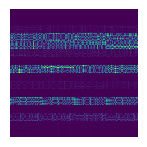

In [11]:
train, test = format_samples(train_samples, test_samples)

In [9]:
print ("train_samples.shape: ", train.shape) # shape = (samples, channels, height, width)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test.shape) # shape = (samples, channels, height, width)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)

train = np.transpose(train, (0,2,3,1))
test = np.transpose(test, (0,2,3,1))

print ("train_samples.shape: ", train.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)


train_samples.shape:  (17431, 3, 128, 128)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 3, 128, 128)
label_array_test.shape:  (99, 1)
train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)


# Network

In [10]:
import time
import json
import logging as log
import sys

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt
# import keras
import tensorflow as tf
print(tf.__version__)

# import keras.backend as K
import tensorflow.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)


def gen_net():
    '''
    TODO: Generate and evaluate any CNN instead of MLPs
    :param vec_len:
    :param num_hidden1:
    :param num_hidden2:
    :return:
    '''


    # input_shape deve essere 30x30, cioé la grandezza dell'immagine di training che abbiamo
    # il parametro include_top parametrizzato a false indica che non verrá caricato l'ultimo layer
    vgg = VGG16(
        input_shape=(128,128,3), 
        weights = 'imagenet', 
        include_top = False)

    # Passaggio fondamentale é non trainare i pesi esistenti in vgg
    for layer in vgg.layers:
        layer.trainable = False

    
    base_outputs = vgg.output
    flatten_outputs = Flatten()(base_outputs)
    final_outputs = Dense(1)(flatten_outputs)
    new_model = Model(inputs = vgg.input, outputs = final_outputs) 
    new_model.summary()

    return new_model


# def gen_net(vec_len, num_hidden1, num_hidden2 ):
#     '''
#     TODO: Generate and evaluate any CNN instead of MLPs
#     :param vec_len:
#     :param num_hidden1:
#     :param num_hidden2:
#     :return:
#     '''

#     model = Sequential()
#     model.add(Dense(num_hidden1, activation='relu', input_shape=(vec_len,)))
#     model.add(Dense(num_hidden2, activation='relu'))
#     model.add(Dense(1))

#     return model

class network_fit(object):
    '''
    class for network
    '''

    def __init__(self, train_samples, label_array_train, test_samples, label_array_test,
                 model_path, n_hidden1 =100, n_hidden2 =10, verbose=2):
        '''
        Constructor
        Generate a NN and train
        @param none
        '''
        # self.__logger = logging.getLogger('data preparation for using it as the network input')
        self.train_samples = train_samples
        self.label_array_train = label_array_train
        self.test_samples = test_samples
        self.label_array_test = label_array_test
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.model_path = model_path
        self.verbose = verbose

        # self.mlps = gen_net(self.train_samples.shape[1], self.n_hidden1, self.n_hidden2)
        self.mlps = gen_net()



    def train_net(self, epochs = 1000, batch_size= 700, lr= 1e-05, plotting=False):
        '''
        specify the optimizers and train the network
        :param epochs:
        :param batch_size:
        :param lr:
        :return:
        '''
        print("Initializing network...")
        # compile the model
        rp = optimizers.RMSprop(learning_rate=lr, rho=0.9, centered=True)
        adm = optimizers.Adam(learning_rate=lr, epsilon=1)
        sgd_m = optimizers.SGD(learning_rate=lr)

        keras_rmse = tf.keras.metrics.RootMeanSquaredError()
        self.mlps.compile(loss='mean_squared_error', optimizer=sgd_m, metrics=[keras_rmse, 'mae'])

        print(self.mlps.summary())

        # Train the model
        history = self.mlps.fit(self.train_samples, self.label_array_train, epochs=epochs, batch_size=batch_size,
                                validation_split=0.2, verbose=self.verbose,
                                callbacks=[
                               EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0, patience=50, verbose=self.verbose, mode='min'),
                               ModelCheckpoint(self.model_path, monitor='val_root_mean_squared_error', save_best_only=True, mode='min',
                                               verbose=self.verbose)])

        val_rmse_k = history.history['val_root_mean_squared_error']
        val_rmse_min = min(val_rmse_k)
        min_val_rmse_idx = val_rmse_k.index(min(val_rmse_k))
        stop_epoch = min_val_rmse_idx +1
        val_rmse_min = round(val_rmse_min, 4)
        print ("val_rmse_min: ", val_rmse_min)

        trained_net = self.mlps

        ## Plot training & validation loss about epochs
        if plotting == True:
            # summarize history for Loss
            fig_acc = plt.figure(figsize=(10, 10))
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.ylim(0, 2000)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()


        return trained_net



    def test_net(self, trained_net=None, best_model=True, plotting=True):
        '''
        Evalute the trained network on test set
        :param trained_net:
        :param best_model:
        :param plotting:
        :return:
        '''
        # Load the trained model
        if best_model:
            estimator = load_model(self.model_path)
        else:
            estimator = load_model(trained_net)

        # predict the RUL
        y_pred_test = estimator.predict(self.test_samples)
        y_true_test = self.label_array_test # ground truth of test samples

        pd.set_option('display.max_rows', 1000)
        test_print = pd.DataFrame()
        test_print['y_pred'] = y_pred_test.flatten()
        test_print['y_truth'] = y_true_test.flatten()
        test_print['diff'] = abs(y_pred_test.flatten() - y_true_test.flatten())
        test_print['diff(ratio)'] = abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()
        test_print['diff(%)'] = (abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()) * 100

        y_predicted = test_print['y_pred']
        y_actual = test_print['y_truth']
        rms = sqrt(mean_squared_error(y_actual, y_predicted)) # RMSE metric
        test_print['rmse'] = rms
        print(test_print)


        # Score metric
        h_array = y_predicted - y_actual
        s_array = np.zeros(len(h_array))
        for j, h_j in enumerate(h_array):
            if h_j < 0:
                s_array[j] = math.exp(-(h_j / 13)) - 1

            else:
                s_array[j] = math.exp(h_j / 10) - 1
        score = np.sum(s_array)

        # Plot the results of RUL prediction
        if plotting == True:
            fig_verify = plt.figure(figsize=(12, 6))
            plt.plot(y_pred_test, color="blue")
            plt.plot(y_true_test, color="green")
            plt.title('prediction')
            plt.ylabel('value')
            plt.xlabel('row')
            plt.legend(['predicted', 'actual data'], loc='upper left')
            plt.show()

        return rms, score

2.4.1


In [11]:
# Creo l'oggetto net
mlps_net = network_fit(train, label_array_train, test, label_array_test,
                       model_path = model_path, n_hidden1=n_hidden1, n_hidden2=n_hidden2, verbose=verbose)

mlps = mlps_net.mlps

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
# compile the model
# Settaggi fit
epochs = 1000 
batch_size= 700 
lr= 1e-05

# Optimizers
rp = optimizers.RMSprop(learning_rate=lr, rho=0.9, centered=True)
adm = optimizers.Adam(learning_rate=lr, epsilon=1)
sgd_m = optimizers.SGD(learning_rate=lr)
# RMSE
keras_rmse = tf.keras.metrics.RootMeanSquaredError()
# Compiling
mlps.compile(loss='mean_squared_error', optimizer=adm, metrics=[keras_rmse, 'mae'])




In [ ]:
# Train the model
history = mlps.fit(train, label_array_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, verbose=1)

Epoch 1/1000
